In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [2]:
#hyperfine reduced matrix element <F||d||F'>
def __Fg_d_Fe(Jg_d_Je, Fg, Fe, Jg, Je, I):
    return (
    Jg_d_Je * (-1)**(Fe+Jg+1+I) * 
        np.sqrt( (2*Fe+1)*(2*Jg+1) ) 
        * wigner_6j(Jg, Je, 1, Fe, Fg, I)
    )

In [3]:
#reduced matrix element <Jg||d||Je>
def __Jg_d_Je(omega_0, Jg, Je, tau):
    return np.sqrt(
        3*np.pi*epsilon0*hbar*c**3/omega_0**3/tau
        * (2*Je+1)/(2*Jg+1)
    )

In [4]:
def Rabi_clock(Fg, Fe, mg, me, d, pol):
    q = -(me-mg)
    Jg_d_Je = d
    
    CG_coeff = float(CG(Fe, me, 1, q, Fg, mg).doit())
    
    Eplus = pol * np.sqrt( intensity / 2 / epsilon0 / c)
    
    return (
    -2 * Jg_d_Je / hbar * Eplus * CG_coeff
    )
    

In [5]:
wH = 0.025e-3
wV = wH
P = 0.6*80e-3
intensity = 2*P/np.pi/wV/wH
d = 4.5*hbar

In [6]:
Rabi_clock(1/2, 1/2, 1/2, -1/2, 4.5*hbar,  1)/1e6/2/np.pi

0.11223749592894952

In [7]:
Rabi_clock(1/2, 1/2, 1/2, 1/2, 4.5*hbar,  1)/1e6/2/np.pi

-0.07936389447475771

In [8]:
print(float(CG(1/2, -1/2, 1, 1, 1/2, 1/2).doit()))
print(float(CG(1/2, 1/2, 1, -1, 1/2, -1/2).doit()))

-0.816496580927726
0.816496580927726


In [9]:
def cos_fit(t, f, phi):
    return -np.cos(2*np.pi*t*f+phi)*1/2+1/2

In [10]:
one = basis(4,0)
two = basis(4,1)
three = basis(4,2)
four = basis(4,3)

sig_11 = one*one.dag()
sig_22 = two*two.dag()
sig_33 = three*three.dag()
sig_44 = four*four.dag()

sig_12 = one*two.dag()
sig_21 = two*one.dag()

sig_13 = one*three.dag()
sig_31 = three*one.dag()

sig_24 = two*four.dag()
sig_42 = four*two.dag()

sig_34 = three*four.dag()
sig_43 = four*three.dag()

In [11]:
B = 6.1*0.5e-4 #magnetic field in T
print('Magnetic field B', B*1e4, 'G')

delta_Ne = -2*np.pi*582*B*1e4 #excited
delta_Ng = -2*np.pi*375*B*1e4 #ground
Fg=1/2
Fe=1/2

Magnetic field B 3.05 G


In [12]:
dt = 1e-8
t_ls = np.arange(0, 1000*dt, dt)

In [13]:
#diagonal terms
diag_1 = -delta_Ng

diag_2 = -delta_Ne

diag_3 = delta_Ne

diag_4 = delta_Ng

In [14]:
psi0 = 1/np.sqrt(2)*(one+four)

phi = 0
angle_pol = 0

## polarization ##
##################

#basis
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phi)*z)

#spherical tensor
pi_pol = x
sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

#off-diagonal terms
offdiag_21 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
offdiag_31 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
offdiag_24 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
offdiag_34 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

offdiag_12 = np.conjugate(offdiag_21)
offdiag_13 = np.conjugate(offdiag_31)
offdiag_42 = np.conjugate(offdiag_24)
offdiag_43 = np.conjugate(offdiag_34)

H0 = (
diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

  + offdiag_12*sig_12 + offdiag_21*sig_21
  + offdiag_13*sig_13 + offdiag_31*sig_31

  + offdiag_24*sig_24 + offdiag_42*sig_42
  + offdiag_43*sig_43 + offdiag_34*sig_34

 ) 

H = H0

c_ops = []

options = qutip.solver.Options(nsteps=100000)

psi_i = 1/np.sqrt(2)*(two-three)

output = mesolve(H, psi0, t_ls, c_ops, [psi_i*psi_i.dag()], options=options, progress_bar=True)



10.1%. Run time:   0.03s. Est. time left: 00:00:00:00
20.1%. Run time:   0.05s. Est. time left: 00:00:00:00
30.1%. Run time:   0.05s. Est. time left: 00:00:00:00
40.1%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.05s. Est. time left: 00:00:00:00
60.0%. Run time:   0.05s. Est. time left: 00:00:00:00
70.0%. Run time:   0.05s. Est. time left: 00:00:00:00
80.0%. Run time:   0.05s. Est. time left: 00:00:00:00
90.0%. Run time:   0.05s. Est. time left: 00:00:00:00
Total run time:   0.05s


(0.0, 1.0)

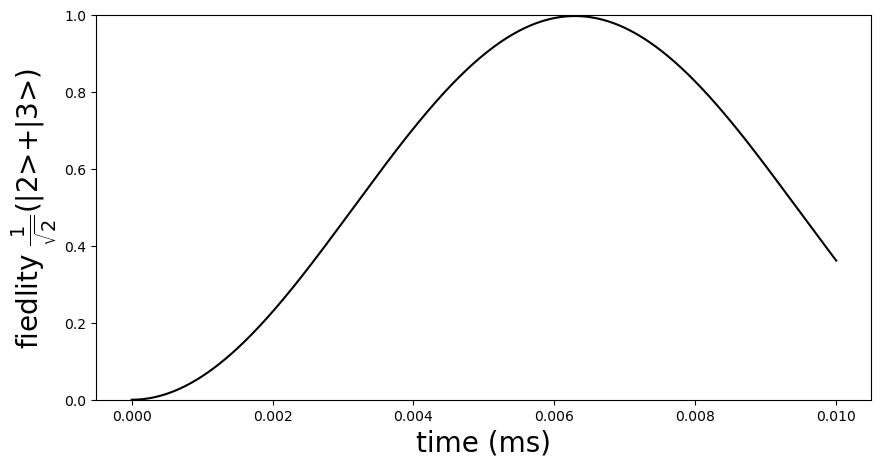

In [15]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(t_ls*1e3, output.expect[0], color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'fiedlity $\frac{1}{\sqrt{2}}$(|2>+|3>)', fontsize=20)
axes.set_ylim(0., 1)
#axes.set_xlim(0, 0.01)

## Function of polarization

In [50]:
B = 6.1*0.5e-4 #magnetic field in T
print('Magnetic field B', B*1e4, 'G')

delta_Ne = -2*np.pi*582*B*1e4 #excited
delta_Ng = -2*np.pi*375*B*1e4 #ground
Fg=1/2
Fe=1/2

Magnetic field B 3.05 G


In [51]:
#diagonal terms
diag_1 = -delta_Ng

diag_2 = -delta_Ne

diag_3 = delta_Ne

diag_4 = delta_Ng

In [52]:
dt = 1e-8
t_ls = np.arange(0, 1000*dt, dt)

psi0 = 1/np.sqrt(2)*(one+four)

phi_ls = np.linspace(-np.pi/2, np.pi/2, 20)
angle_pol_ls = np.linspace(-np.pi/30, np.pi/30, 20)

## polarization ##
##################

#basis
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

#spherical tensor
pi_pol = x
sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

result_ls = []
i = 0
for phi in phi_ls:
    for angle_pol in angle_pol_ls:

        polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phi)*z)

        #off-diagonal terms
        offdiag_21 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
        offdiag_31 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
        offdiag_24 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
        offdiag_34 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

        offdiag_12 = np.conjugate(offdiag_21)
        offdiag_13 = np.conjugate(offdiag_31)
        offdiag_42 = np.conjugate(offdiag_24)
        offdiag_43 = np.conjugate(offdiag_34)

        H0 = (
        diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

          + offdiag_12*sig_12 + offdiag_21*sig_21
          + offdiag_13*sig_13 + offdiag_31*sig_31

          + offdiag_24*sig_24 + offdiag_42*sig_42
          + offdiag_43*sig_43 + offdiag_34*sig_34

         ) 

        H = H0

        c_ops = []

        options = qutip.solver.Options(nsteps=100000)

        psi_i = 1/np.sqrt(2)*(two-three)

        output = mesolve(H, psi0, t_ls, c_ops, [psi_i*psi_i.dag()], options=options)
        #print(i)
        i+=1
        
        result_ls.append([np.max(output.expect[0]), phi, angle_pol])
    print(i)
        

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400


In [53]:
fidelity = np.array(result_ls)[:, 0]
fidelity = fidelity.reshape(len(phi_ls), len(angle_pol_ls))

Text(0.5, 0, 'angle between hor and ver (deg)')

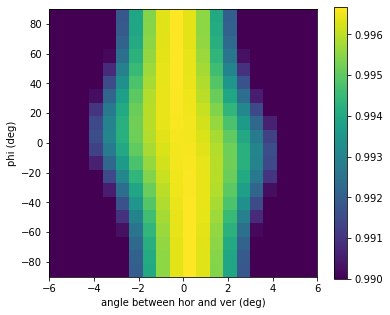

In [54]:
extent = np.min(angle_pol_ls)*180/np.pi, np.max(angle_pol_ls)*180/np.pi, np.min(phi_ls)*180/np.pi, np.max(phi_ls)*180/np.pi
plt.figure(figsize=(6,5))
plt.imshow(fidelity, cmap=plt.cm.viridis, origin='lower',
    extent=extent, vmin=0.99, aspect = (extent[1]-extent[0])/(extent[3]-extent[2]))
plt.colorbar()
plt.ylabel('phi (deg)')
plt.xlabel('angle between hor and ver (deg)')

## Function of Bfield

In [26]:
Fg=1/2
Fe=1/2

In [27]:
phi = 0
angle_pol = 0

x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

#spherical tensor
pi_pol = x
sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phi)*z)

#off-diagonal terms
offdiag_21 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
offdiag_31 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
offdiag_24 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
offdiag_34 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

offdiag_12 = np.conjugate(offdiag_21)
offdiag_13 = np.conjugate(offdiag_31)
offdiag_42 = np.conjugate(offdiag_24)
offdiag_43 = np.conjugate(offdiag_34)

In [32]:
offdiag_21/2/np.pi*2

(79363.89447475772+0j)

In [39]:
m = 100
dt = abs(np.pi/offdiag_21/m)
t_ls = np.arange(0, (m+1)*dt, dt)

psi0 = 1/np.sqrt(2)*(one+four)



## polarization ##
##################

#basis
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

#spherical tensor
pi_pol = x
sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

result_ls = []
i = 0

B_ls = np.linspace(0, 4.8, 100)*6.8e-4
for B in B_ls:
    

    delta_Ne = -2*np.pi*582*B*1e4 #excited
    delta_Ng = -2*np.pi*375*B*1e4 #ground

    #diagonal terms
    diag_1 = -delta_Ng

    diag_2 = -delta_Ne

    diag_3 = delta_Ne

    diag_4 = delta_Ng



    H0 = (
    diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

      + offdiag_12*sig_12 + offdiag_21*sig_21
      + offdiag_13*sig_13 + offdiag_31*sig_31

      + offdiag_24*sig_24 + offdiag_42*sig_42
      + offdiag_43*sig_43 + offdiag_34*sig_34

     ) 

    H = H0

    c_ops = []

    options = qutip.solver.Options(nsteps=100000)

    psi_i = 1/np.sqrt(2)*(two-three)

    output = mesolve(H, psi0, t_ls, c_ops, [psi_i*psi_i.dag()], options=options)
    #print(i)
    i+=1

    result_ls.append(np.max(output.expect[0]))


In [40]:
fidelity = np.array(result_ls)

Text(0, 0.5, 'fiedlity $\\frac{1}{\\sqrt{2}}$(|2>-|3>)')

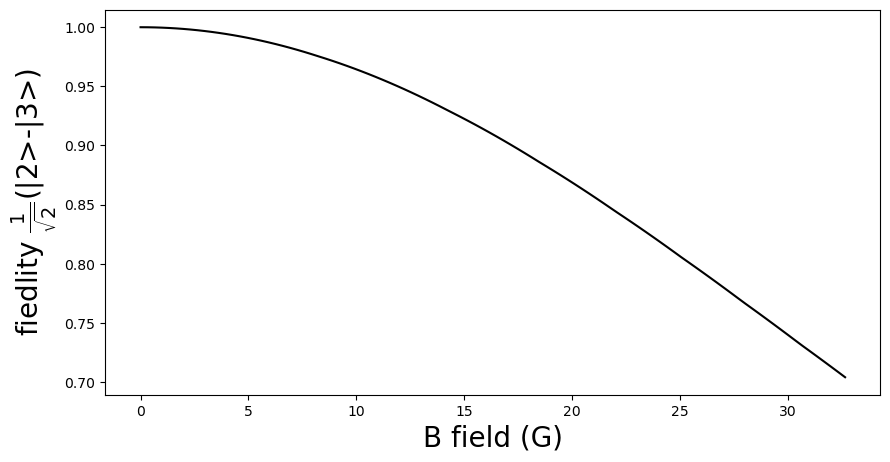

In [41]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(B_ls*1e4, fidelity, color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'B field (G)', fontsize=20)
axes.set_ylabel(r'fiedlity $\frac{1}{\sqrt{2}}$(|2>-|3>)', fontsize=20)
#axes.set_ylim(0.9, 1)
#axes.set_xlim(0, 0.01)

## Shelve qubit up

In [118]:
def Hp_coeff(t, args):
    return np.exp(1j*delta*t)

def Hm_coeff(t, args):
    return np.exp(-1j*delta*t)


result_ls = []
i = 0

B_ls = np.linspace(0, 4.8, 100)*6.8e-4
for B in B_ls:
    

    delta_Ne = -2*np.pi*582*B*1e4 #excited
    delta_Ng = -2*np.pi*375*B*1e4 #ground
    
    
    ##########################################
    ## Hamiltonian 1: 1st pi pulse  ##
    #####################################3####
   
    #diagonal terms for the first pulse
    diag_1_1 = -delta_Ng
    diag_2_1 = -delta_Ne
    diag_3_1 = delta_Ne
    diag_4_1 = delta_Ng
    
    # off-diagonal terms 
    phi_1 = 0
    angle_pol_1 = 5e-2
    polarization_1 = (np.cos(angle_pol_1)*x+np.sin(angle_pol_1)*np.exp(-1j*phi_1)*z)

    offdiag_21_1 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization_1, pi_pol)) / 2
    offdiag_31_1 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization_1, sigp_pol)) / 2
    offdiag_24_1 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization_1, sigm_pol)) / 2
    offdiag_34_1 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization_1, pi_pol)) / 2


    H1_diag = diag_1_1*sig_11 + diag_2_1*sig_22 + diag_3_1*sig_33 + diag_4_1*sig_44

    H1_offdiag = offdiag_21_1*sig_21 + offdiag_31_1*sig_31 + offdiag_24_1*sig_24 + offdiag_34_1*sig_34

    H1_conj = ( np.conjugate(offdiag_21_1)*sig_12 + np.conjugate(offdiag_31_1)*sig_13 + 
                np.conjugate(offdiag_24_1)*sig_42 + np.conjugate(offdiag_34_1)*sig_43 )

    ###################################
    # calibrate pi
    ############################
    psi0 = 1/np.sqrt(2)*(one+four)
    psi_i = 1/np.sqrt(2)*(two-three)
   
    m = 100
    dt = abs(np.pi/offdiag_21/m)
    t_ls = np.arange(0, (m+1)*dt, dt)
    
    delta = 0
    
    output = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], psi0, t_ls, 
                      c_ops, [psi_i*psi_i.dag()], options=options)
    
    pi_time_idx = np.where(output.expect[0] == np.max(output.expect[0]))[0][0]
    pi_time1 = t_ls[pi_time_idx]

    
    ###################################
    psi0 = 1/np.sqrt(2)*(one+four)
    psii = 1/np.sqrt(2)*(two-three)
   
    m = 100
    dt = abs(np.pi/offdiag_21/m)
    t_ls = np.arange(0, (m+1)*dt, dt)
    
    delta = 0
    psi3_ls = []
    for clockphase in np.linspace(0, 2*np.pi, 100):
        delta = 0
        psi3 = mesolve([H1_diag, [H1_offdiag*np.exp(-1j*clockphase), Hp_coeff], [H1_conj*np.exp(1j*clockphase), Hm_coeff]], psi0, 
                       np.arange(0, pi_time1, dt), c_ops, 
                       [psii*psii.dag()], 
                       options=options).expect[0][-1]
        psi3_ls.append(psi3)

   
    result_ls.append(np.max(psi3_ls))


In [119]:
fidelity = np.array(result_ls)

(0.0, 5.0)

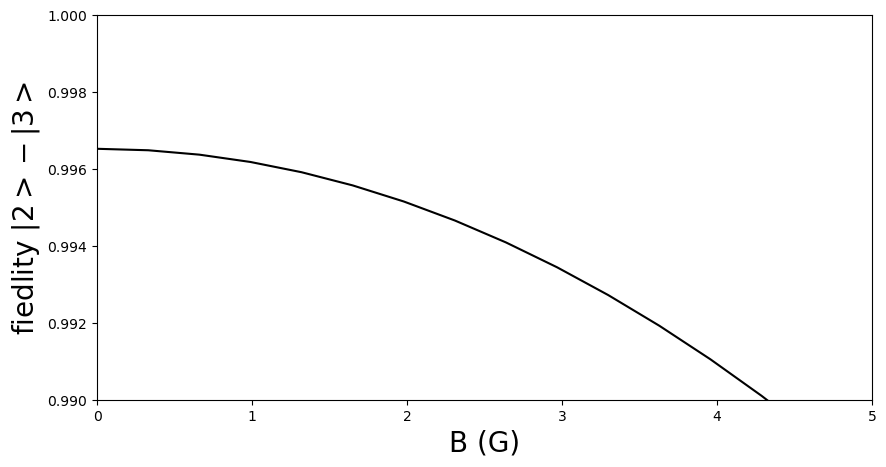

In [122]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(B_ls*1e4, fidelity, color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'B (G)', fontsize=20)
axes.set_ylabel(r'fiedlity $|2>-|3>$', fontsize=20)
axes.set_ylim(0.99, 1)
axes.set_xlim(0, 5)

## Shelve qubit up and down

In [110]:
def Hp_coeff(t, args):
    return np.exp(1j*delta*t)

def Hm_coeff(t, args):
    return np.exp(-1j*delta*t)


result_ls = []
i = 0

B_ls = np.linspace(2, 4.8, 20)*6.8e-4
for B in B_ls:
    

    delta_Ne = -2*np.pi*582*B*1e4 #excited
    delta_Ng = -2*np.pi*375*B*1e4 #ground
    
    
    ##########################################
    ## Hamiltonian 1: 1st pi pulse  ##
    #####################################3####
   
    #diagonal terms for the first pulse
    diag_1_1 = -delta_Ng
    diag_2_1 = -delta_Ne
    diag_3_1 = delta_Ne
    diag_4_1 = delta_Ng
    
    # off-diagonal terms 
    phi_1 = 0
    angle_pol_1 = 5e-2
    polarization_1 = (np.cos(angle_pol_1)*x+np.sin(angle_pol_1)*np.exp(-1j*phi_1)*z)

    offdiag_21_1 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization_1, pi_pol)) / 2
    offdiag_31_1 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization_1, sigp_pol)) / 2
    offdiag_24_1 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization_1, sigm_pol)) / 2
    offdiag_34_1 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization_1, pi_pol)) / 2


    H1_diag = diag_1_1*sig_11 + diag_2_1*sig_22 + diag_3_1*sig_33 + diag_4_1*sig_44

    H1_offdiag = offdiag_21_1*sig_21 + offdiag_31_1*sig_31 + offdiag_24_1*sig_24 + offdiag_34_1*sig_34

    H1_conj = ( np.conjugate(offdiag_21_1)*sig_12 + np.conjugate(offdiag_31_1)*sig_13 + 
                np.conjugate(offdiag_24_1)*sig_42 + np.conjugate(offdiag_34_1)*sig_43 )

    ###################################
    # calibrate pi
    ############################
    psi0 = 1/np.sqrt(2)*(one+four)
    psi_i = 1/np.sqrt(2)*(two-three)
   
    m = 100
    dt = abs(np.pi/offdiag_21/m)
    t_ls = np.arange(0, (m+1)*dt, dt)
    
    delta = 0
    
    output = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], psi0, t_ls, 
                      c_ops, [psi_i*psi_i.dag()], options=options)
    
    pi_time_idx = np.where(output.expect[0] == np.max(output.expect[0]))[0][0]
    pi_time1 = t_ls[pi_time_idx]

    
    ##########################################
    ## Hamiltonian 2: 2nd pi pulse  ##
    #####################################3####
   
    #diagonal terms for the first pulse
    diag_1_2 = -delta_Ng
    diag_2_2 = -delta_Ne
    diag_3_2 = delta_Ne
    diag_4_2 = delta_Ng
    
    # off-diagonal terms 
    phi_2 = 0
    angle_pol_2 = 5e-2
    polarization_2 = (np.cos(angle_pol_2)*x+np.sin(angle_pol_2)*np.exp(-1j*phi_2)*z)

    offdiag_21_2 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization_2, pi_pol)) / 2
    offdiag_31_2 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization_2, sigp_pol)) / 2
    offdiag_24_2 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization_2, sigm_pol)) / 2
    offdiag_34_2 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization_2, pi_pol)) / 2


    H2_diag = diag_1_2*sig_11 + diag_2_2*sig_22 + diag_3_2*sig_33 + diag_4_2*sig_44

    H2_offdiag = offdiag_21_2*sig_21 + offdiag_31_2*sig_31 + offdiag_24_2*sig_24 + offdiag_34_2*sig_34

    H2_conj = ( np.conjugate(offdiag_21_2)*sig_12 + np.conjugate(offdiag_31_2)*sig_13 + 
                np.conjugate(offdiag_24_2)*sig_42 + np.conjugate(offdiag_34_2)*sig_43 )

    ###################################
    # calibrate pi
    ############################
    psi0 = 1/np.sqrt(2)*(two-three)
    psi_i = 1/np.sqrt(2)*(one+four)
   
    m = 100
    dt = abs(np.pi/offdiag_21/m)
    t_ls = np.arange(0, (m+1)*dt, dt)
    
    delta = 0
    
    output = mesolve([H2_diag, [H2_offdiag, Hp_coeff], [H2_conj, Hm_coeff]], psi0, t_ls, 
                      c_ops, [psi_i*psi_i.dag()], options=options)
    
    pi_time_idx = np.where(output.expect[0] == np.max(output.expect[0]))[0][0]
    pi_time2 = t_ls[pi_time_idx]
    
    
    ##########################################
    ## Hamiltonian wait:                    ##
    #####################################3####
    
    LS = 2*np.pi*42e3
    #diagonal terms for the first pulse
    diag_1_w = -delta_Ng + LS/2
    diag_2_w = -delta_Ne - LS/2
    diag_3_w = delta_Ne - LS/2
    diag_4_w = delta_Ng + LS/2
    
    H_wait = diag_1_w*sig_11 + diag_2_w*sig_22 + diag_3_w*sig_33 + diag_4_w*sig_44
    
    
    ###################################
    psi0 = 1/np.sqrt(2)*(one+four)
    psi_i = 1/np.sqrt(2)*(two-three)
   
    m = 100
    dt = abs(np.pi/offdiag_21/m)
    t_ls = np.arange(0, (m+1)*dt, dt)
    
    delta = 0
    
    psi1 = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], psi0, 
                   np.linspace(0, pi_time1, 30), c_ops, 
                   options=options).states[-1]
    
    psif = []
    for twait in np.linspace(1e-3, 1.2e-3, 100):

        psi2 = mesolve(H_wait, psi1, 
                       np.arange(pi_time1, pi_time1+twait, np.pi/LS/50), c_ops, 
                       options=options).states[-1]

        psi3_ls = []
        for clockphase in np.linspace(0, 2*np.pi, 100):
            delta = 0
            psi3 = mesolve([H2_diag, [H2_offdiag*np.exp(-1j*clockphase), Hp_coeff], [H2_conj*np.exp(1j*clockphase), Hm_coeff]], psi2, 
                           np.linspace(pi_time1+twait, pi_time1+twait+pi_time2, 30), c_ops, 
                           [psi0*psi0.dag()], 
                           options=options).expect[0][-1]
            psi3_ls.append(psi3)

        psif.append(np.max(psi3_ls))
   
    result_ls.append(np.max(psif))


In [111]:
fidelity = np.array(result_ls)

(0.95, 1.0)

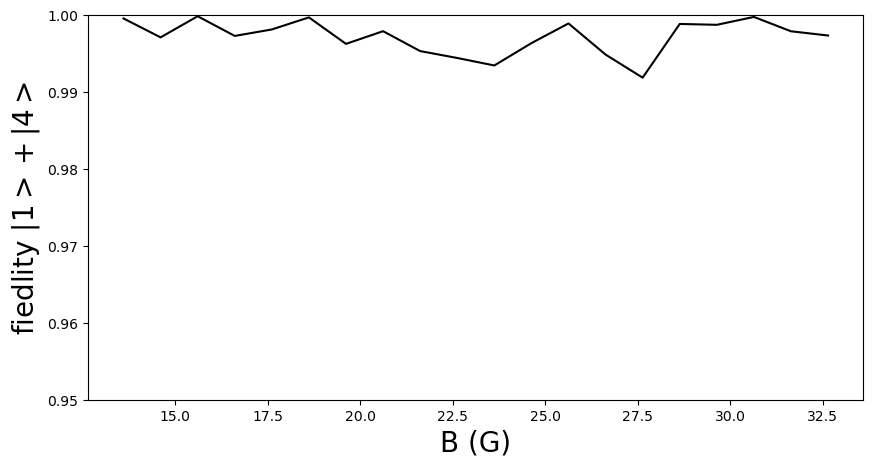

In [112]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(B_ls*1e4, fidelity, color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'B (G)', fontsize=20)
axes.set_ylabel(r'fiedlity $|1>+|4>$', fontsize=20)
axes.set_ylim(0.95, 1)
#axes.set_xlim(0, 5)

## Function of waittime

In [101]:
B = 6.8*4.8e-4 #magnetic field in T
print('Magnetic field B', B*1e4, 'G')

delta_Ne = -2*np.pi*582*B*1e4 #excited
delta_Ng = -2*np.pi*375*B*1e4 #ground
Fg=1/2
Fe=1/2

Magnetic field B 32.64 G


In [102]:
dt = 1e-8
t_ls = np.arange(0, 1000*dt, dt)

In [103]:
#diagonal terms
diag_1 = -delta_Ng

diag_2 = -delta_Ne 

diag_3 = delta_Ne

diag_4 = delta_Ng

#light shift
LS = 2*np.pi*50e3

diag_2LS = -delta_Ne - LS

diag_3LS = delta_Ne - LS

In [104]:
psi0 = 1/np.sqrt(2)*(one+four)

phi = 0
angle_pol = 0

## polarization ##
##################

#basis
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phi)*z)

#spherical tensor
pi_pol = x
sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

#off-diagonal terms
offdiag_21 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
offdiag_31 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
offdiag_24 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
offdiag_34 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

offdiag_12 = np.conjugate(offdiag_21)
offdiag_13 = np.conjugate(offdiag_31)
offdiag_42 = np.conjugate(offdiag_24)
offdiag_43 = np.conjugate(offdiag_34)

H0 = (
diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

  + offdiag_12*sig_12 + offdiag_21*sig_21
  + offdiag_13*sig_13 + offdiag_31*sig_31

  + offdiag_24*sig_24 + offdiag_42*sig_42
  + offdiag_43*sig_43 + offdiag_34*sig_34

 ) 

H = H0

c_ops = []

options = qutip.solver.Options(nsteps=100000)

psi_i = 1/np.sqrt(2)*(two+three)

output = mesolve(H, psi0, t_ls, c_ops, [psi_i*psi_i.dag()], options=options, progress_bar=True)

pi_time_idx = np.where(output.expect[0] == np.max(output.expect[0]))[0][0]
pi_time = t_ls[pi_time_idx]


10.1%. Run time:   0.02s. Est. time left: 00:00:00:00
20.1%. Run time:   0.02s. Est. time left: 00:00:00:00
30.1%. Run time:   0.02s. Est. time left: 00:00:00:00
40.1%. Run time:   0.02s. Est. time left: 00:00:00:00
50.0%. Run time:   0.02s. Est. time left: 00:00:00:00
60.0%. Run time:   0.02s. Est. time left: 00:00:00:00
70.0%. Run time:   0.02s. Est. time left: 00:00:00:00
80.0%. Run time:   0.03s. Est. time left: 00:00:00:00
90.0%. Run time:   0.03s. Est. time left: 00:00:00:00
Total run time:   0.03s


In [105]:
t_wait = np.linspace(1e-6, .5e-3, 1000)

result = []

for time in t_wait:
    psi0 = 1/np.sqrt(2)*(one+four)

    phi = 0
    angle_pol = 0

    ## polarization ##
    ##################

    #basis
    x = np.array([1,0,0])
    y = np.array([0,1,0])
    z = np.array([0,0,1])

    polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phi)*z)

    #spherical tensor
    pi_pol = x
    sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
    sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

    #off-diagonal terms
    offdiag_21 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
    offdiag_31 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
    offdiag_24 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
    offdiag_34 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

    offdiag_12 = np.conjugate(offdiag_21)
    offdiag_13 = np.conjugate(offdiag_31)
    offdiag_42 = np.conjugate(offdiag_24)
    offdiag_43 = np.conjugate(offdiag_34)

    H0 = (
    diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

      + offdiag_12*sig_12 + offdiag_21*sig_21
      + offdiag_13*sig_13 + offdiag_31*sig_31

      + offdiag_24*sig_24 + offdiag_42*sig_42
      + offdiag_43*sig_43 + offdiag_34*sig_34

     ) 
    

    H1 = H0
    H2 = diag_1*sig_11 + diag_2LS*sig_22 + diag_3LS*sig_33 + diag_4*sig_44
    H3 = H0

    c_ops = []

    options = qutip.solver.Options(nsteps=100000)

    psi_i = 1/np.sqrt(2)*(one+four)

    psi1 = mesolve(H1, psi0, np.arange(0, pi_time, pi_time/30), c_ops, options=options).states[-1]
    psi2 = mesolve(H2, psi1, np.arange(pi_time, pi_time+time, pi_time/30), c_ops, options=options).states[-1]
    psi3 = mesolve(H3, psi2, np.arange(pi_time+time, 2*pi_time+time, pi_time/30), c_ops, [psi_i*psi_i.dag()], options=options)

    result.append(psi3.expect[0][-1])

(0.0, 1.0)

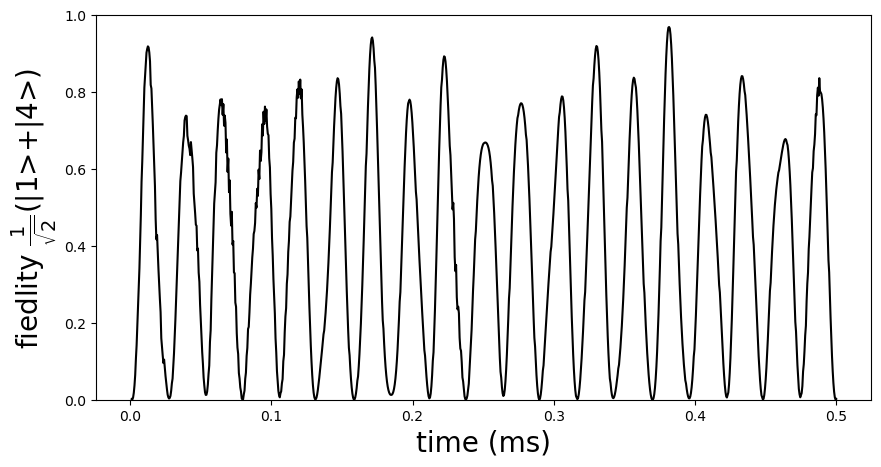

In [106]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(t_wait*1e3, result, color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'fiedlity $\frac{1}{\sqrt{2}}$(|1>+|4>)', fontsize=20)
axes.set_ylim(0., 1)
#axes.set_xlim(0.75, 1)

In [100]:
t_wait = 5e-3
phase_ls = np.linspace(0, 2*np.pi, 100)

result = []

for phase in phase_ls:
    psi0 = 1/np.sqrt(2)*(one+four)

    phi = 0
    angle_pol = 0

    ## polarization ##
    ##################

    #basis
    x = np.array([1,0,0])
    y = np.array([0,1,0])
    z = np.array([0,0,1])

    polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phi)*z)

    #spherical tensor
    pi_pol = x
    sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
    sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

    #off-diagonal terms
    offdiag_21 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
    offdiag_31 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
    offdiag_24 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
    offdiag_34 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

    offdiag_12 = np.conjugate(offdiag_21)
    offdiag_13 = np.conjugate(offdiag_31)
    offdiag_42 = np.conjugate(offdiag_24)
    offdiag_43 = np.conjugate(offdiag_34)

    H0 = (
    diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

      + offdiag_12*sig_12 + offdiag_21*sig_21
      + offdiag_13*sig_13 + offdiag_31*sig_31

      + offdiag_24*sig_24 + offdiag_42*sig_42
      + offdiag_43*sig_43 + offdiag_34*sig_34

     ) 
    
    H0_phase = (
    diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

      + offdiag_12*sig_12*np.exp(-1j*phase) + offdiag_21*sig_21*np.exp(1j*phase)
      + offdiag_13*sig_13*np.exp(-1j*phase) + offdiag_31*sig_31*np.exp(1j*phase)

      + offdiag_24*sig_24*np.exp(1j*phase) + offdiag_42*sig_42*np.exp(-1j*phase)
      + offdiag_43*sig_43*np.exp(-1j*phase) + offdiag_34*sig_34*np.exp(1j*phase)

     ) 
    

    H1 = H0
    H2 = diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44
    H3 = H0_phase

    c_ops = []

    options = qutip.solver.Options(nsteps=100000)

    psi_i = 1/np.sqrt(2)*(one+four)

    psi1 = mesolve(H1, psi0, np.arange(0, pi_time, pi_time/30), c_ops, options=options).states[-1]
    psi2 = mesolve(H2, psi1, np.arange(pi_time, pi_time+time, pi_time/30), c_ops, options=options).states[-1]
    psi3 = mesolve(H3, psi2, np.arange(pi_time+time, 2*pi_time+time, pi_time/30), c_ops, [psi_i*psi_i.dag()], options=options)

    result.append(psi3.expect[0][-1])

Text(0, 0.5, 'fiedlity $\\frac{1}{\\sqrt{2}}$(|1>+|4>)')

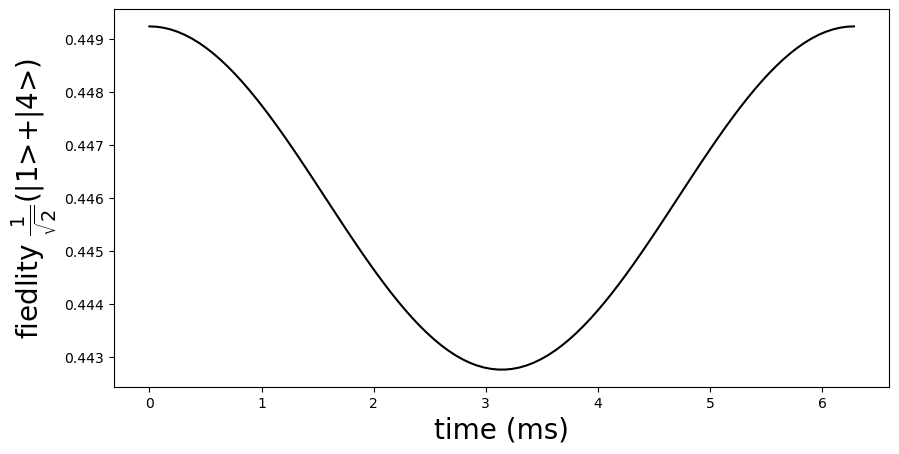

In [103]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(phase_ls, result, color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'fiedlity $\frac{1}{\sqrt{2}}$(|1>+|4>)', fontsize=20)
#axes.set_ylim(0.9, 1)
#axes.set_xlim(0.75, 1)

In [118]:
0.044/0.38/(1-0.044/0.38)

0.13095238095238093

# Shelving with two sigma pulses

In [80]:
Fg=1/2
Fe=1/2

## polarization ##
##################

#basis
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

#spherical tensor
pi_pol = y
sigp_pol = 1/np.sqrt(2)*(z-1j*x)
sigm_pol = -1/np.sqrt(2)*(z+1j*x)

## function of B field

In [187]:

def Hp_coeff(t, args):
    return np.exp(1j*delta*t)

def Hm_coeff(t, args):
    return np.exp(-1j*delta*t)


result_ls = []
i = 0

B_ls = np.linspace(0, 5.5, 100)*6.8e-4
for B in B_ls:
    

    delta_Ne = -2*np.pi*582*B*1e4 #excited
    delta_Ng = -2*np.pi*375*B*1e4 #ground
    
    
    ##########################################
    ## Hamiltonian 1: 1st sigma pulse 4-->2 ##
    #####################################3####
   
    #diagonal terms for the first pulse
    diag_1_1 = -delta_Ng
    diag_2_1 = -delta_Ne
    diag_3_1 = delta_Ne
    diag_4_1 = delta_Ng
    
    # off-diagonal terms 
    phi_1 = -np.pi/2
    angle_pol_1 = np.pi/4
    polarization_1 = (np.cos(angle_pol_1)*x+np.sin(angle_pol_1)*np.exp(-1j*phi_1)*z)

    offdiag_21_1 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization_1, pi_pol)) / 2
    offdiag_31_1 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization_1, sigp_pol)) / 2
    offdiag_24_1 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization_1, sigm_pol)) / 2
    offdiag_34_1 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization_1, pi_pol)) / 2


    H1_diag = diag_1_1*sig_11 + diag_2_1*sig_22 + diag_3_1*sig_33 + diag_4_1*sig_44

    H1_offdiag = offdiag_21_1*sig_21 + offdiag_31_1*sig_31 + offdiag_24_1*sig_24 + offdiag_34_1*sig_34

    H1_conj = ( np.conjugate(offdiag_21_1)*sig_12 + np.conjugate(offdiag_31_1)*sig_13 + 
                np.conjugate(offdiag_24_1)*sig_42 + np.conjugate(offdiag_34_1)*sig_43 )

    ###################################
    # calibrate pi
    ############################
    psi0 = four
    psi_i =  two
   
    dt = 1e-8
    t_ls = np.arange(0, 1000*dt, dt)
    
    delta = (delta_Ng+delta_Ne)
    
    output = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], psi0, t_ls, 
                      c_ops, [psi_i*psi_i.dag()], options=options)
    
    pi_time_idx = np.where(output.expect[0] == np.max(output.expect[0]))[0][0]
    pi_time1 = t_ls[pi_time_idx]

    
    ##########################################
    ## Hamiltonian 2: 2nd sigma pulse 1-->3 ##
    #####################################3####
   
    #diagonal terms for the first pulse
    diag_1_2 = -delta_Ng
    diag_2_2 = -delta_Ne
    diag_3_2 = delta_Ne
    diag_4_2 = delta_Ng
    
    # off-diagonal terms 
    phi_2 = +np.pi/2
    angle_pol_2 = np.pi/4
    polarization_2 = (np.cos(angle_pol_2)*x+np.sin(angle_pol_2)*np.exp(-1j*phi_2)*z)

    offdiag_21_2 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization_2, pi_pol)) / 2
    offdiag_31_2 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization_2, sigp_pol)) / 2
    offdiag_24_2 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization_2, sigm_pol)) / 2
    offdiag_34_2 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization_2, pi_pol)) / 2


    H2_diag = diag_1_2*sig_11 + diag_2_2*sig_22 + diag_3_2*sig_33 + diag_4_2*sig_44

    H2_offdiag = offdiag_21_2*sig_21 + offdiag_31_2*sig_31 + offdiag_24_2*sig_24 + offdiag_34_2*sig_34

    H2_conj = ( np.conjugate(offdiag_21_2)*sig_12 + np.conjugate(offdiag_31_2)*sig_13 + 
                np.conjugate(offdiag_24_2)*sig_42 + np.conjugate(offdiag_34_2)*sig_43 )

    ###################################
    # calibrate pi
    ############################
    psi0 = one
    psi_i = three
   
    dt = 1e-8
    t_ls = np.arange(0, 1000*dt, dt)
    
    delta = -(delta_Ng+delta_Ne)
    
    output = mesolve([H2_diag, [H2_offdiag, Hp_coeff], [H2_conj, Hm_coeff]], psi0, t_ls, 
                      c_ops, [psi_i*psi_i.dag()], options=options)
    
    pi_time_idx = np.where(output.expect[0] == np.max(output.expect[0]))[0][0]
    pi_time2 = t_ls[pi_time_idx]
    
    
    ##########################################
    ## Hamiltonian wait:                    ##
    #####################################3####
    
    LS = 2*np.pi*50e3
    #diagonal terms for the first pulse
    diag_1_w = -delta_Ng + LS/2
    diag_2_w = -delta_Ne - LS/2
    diag_3_w = delta_Ne - LS/2
    diag_4_w = delta_Ng + LS/2
    
    H_wait = diag_1_w*sig_11 + diag_2_w*sig_22 + diag_3_w*sig_33 + diag_4_w*sig_44
    
    
    ###################################
    psi0 = 1/np.sqrt(2)*(one+four)
    psi_i = 1/np.sqrt(2)*(two-three)
   
    dt = 1e-8
    t_ls1 = np.arange(0, 1000*dt, dt)
    
    delta = (delta_Ng+delta_Ne)
    
    psi1 = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], psi0, 
                   np.linspace(0, pi_time1, 30), c_ops, 
                   options=options).states[-1]
    
    twait = 1e-6
    psi2 = mesolve(H_wait, psi1, 
                   np.arange(pi_time1, pi_time1+twait, pi_time1/30), c_ops, 
                   options=options).states[-1]
    
    psi3_ls = []
    for clockphase in np.linspace(0, 2*np.pi, 100):
        delta = -(delta_Ng+delta_Ne)
        psi3 = mesolve([H2_diag, [H2_offdiag*np.exp(-1j*clockphase), Hp_coeff], [H2_conj*np.exp(1j*clockphase), Hm_coeff]], psi2, 
                       np.linspace(pi_time1+twait, pi_time1+twait+pi_time2, 30), c_ops, 
                       [psi_i*psi_i.dag()], 
                       options=options).expect[0][-1]
        psi3_ls.append(psi3)
   
    result_ls.append(np.max(psi3_ls))


In [188]:
fidelity = np.array(result_ls)

(0.999, 1.0)

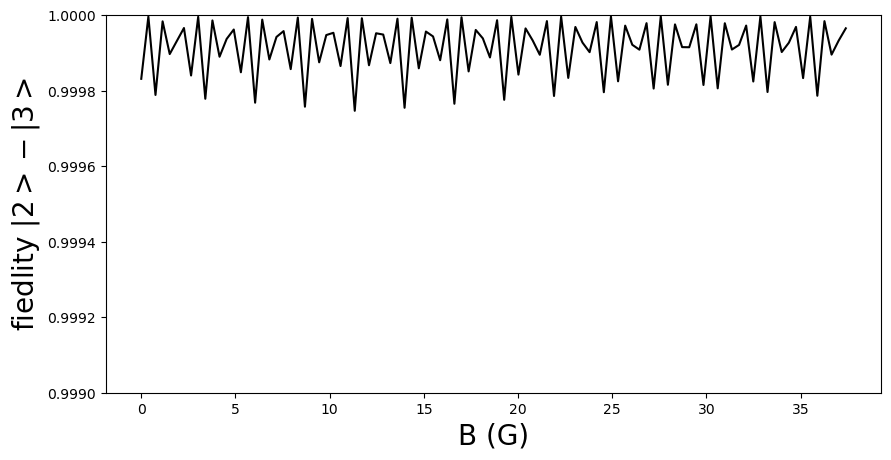

In [190]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(B_ls*1e4, fidelity, color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'B (G)', fontsize=20)
axes.set_ylabel(r'fiedlity $|2>-|3>$', fontsize=20)
axes.set_ylim(0.999, 1)
#axes.set_xlim(0, 0.01)

## function of wait time

In [179]:

def Hp_coeff(t, args):
    return np.exp(1j*delta*t)

def Hm_coeff(t, args):
    return np.exp(-1j*delta*t)


result_ls = []
i = 0

B = 4.8*6.8e-4

twait_ls = np.linspace(1e-7, 100e-6, 100)


for twait in twait_ls:
    

    delta_Ne = -2*np.pi*582*B*1e4 #excited
    delta_Ng = -2*np.pi*375*B*1e4 #ground
    
    
    ##########################################
    ## Hamiltonian 1: 1st sigma pulse 4-->2 ##
    #####################################3####
   
    #diagonal terms for the first pulse
    diag_1_1 = -delta_Ng
    diag_2_1 = -delta_Ne
    diag_3_1 = delta_Ne
    diag_4_1 = delta_Ng
    
    # off-diagonal terms 
    phi_1 = -np.pi/2
    angle_pol_1 = np.pi/4
    polarization_1 = (np.cos(angle_pol_1)*x+np.sin(angle_pol_1)*np.exp(-1j*phi_1)*z)

    offdiag_21_1 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization_1, pi_pol)) / 2
    offdiag_31_1 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization_1, sigp_pol)) / 2
    offdiag_24_1 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization_1, sigm_pol)) / 2
    offdiag_34_1 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization_1, pi_pol)) / 2


    H1_diag = diag_1_1*sig_11 + diag_2_1*sig_22 + diag_3_1*sig_33 + diag_4_1*sig_44

    H1_offdiag = offdiag_21_1*sig_21 + offdiag_31_1*sig_31 + offdiag_24_1*sig_24 + offdiag_34_1*sig_34

    H1_conj = ( np.conjugate(offdiag_21_1)*sig_12 + np.conjugate(offdiag_31_1)*sig_13 + 
                np.conjugate(offdiag_24_1)*sig_42 + np.conjugate(offdiag_34_1)*sig_43 )

    ###################################
    # calibrate pi
    ############################
    psi0 = four
    psi_i =  two
   
    dt = 1e-8
    t_ls = np.arange(0, 1000*dt, dt)
    
    delta = (delta_Ng+delta_Ne)
    
    output = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], psi0, t_ls, 
                      c_ops, [psi_i*psi_i.dag()], options=options)
    
    pi_time_idx = np.where(output.expect[0] == np.max(output.expect[0]))[0][0]
    pi_time1 = t_ls[pi_time_idx]

    
    ##########################################
    ## Hamiltonian 2: 2nd sigma pulse 1-->3 ##
    #####################################3####
   
    #diagonal terms for the first pulse
    diag_1_2 = -delta_Ng
    diag_2_2 = -delta_Ne
    diag_3_2 = delta_Ne
    diag_4_2 = delta_Ng
    
    # off-diagonal terms 
    phi_2 = +np.pi/2
    angle_pol_2 = np.pi/4
    polarization_2 = (np.cos(angle_pol_2)*x+np.sin(angle_pol_2)*np.exp(-1j*phi_2)*z)

    offdiag_21_2 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization_2, pi_pol)) / 2
    offdiag_31_2 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization_2, sigp_pol)) / 2
    offdiag_24_2 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization_2, sigm_pol)) / 2
    offdiag_34_2 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization_2, pi_pol)) / 2


    H2_diag = diag_1_2*sig_11 + diag_2_2*sig_22 + diag_3_2*sig_33 + diag_4_2*sig_44

    H2_offdiag = offdiag_21_2*sig_21 + offdiag_31_2*sig_31 + offdiag_24_2*sig_24 + offdiag_34_2*sig_34

    H2_conj = ( np.conjugate(offdiag_21_2)*sig_12 + np.conjugate(offdiag_31_2)*sig_13 + 
                np.conjugate(offdiag_24_2)*sig_42 + np.conjugate(offdiag_34_2)*sig_43 )

    ###################################
    # calibrate pi
    ############################
    psi0 = one
    psi_i = three
   
    dt = 1e-8
    t_ls = np.arange(0, 1000*dt, dt)
    
    delta = -(delta_Ng+delta_Ne)
    
    output = mesolve([H2_diag, [H2_offdiag, Hp_coeff], [H2_conj, Hm_coeff]], psi0, t_ls, 
                      c_ops, [psi_i*psi_i.dag()], options=options)
    
    pi_time_idx = np.where(output.expect[0] == np.max(output.expect[0]))[0][0]
    pi_time2 = t_ls[pi_time_idx]
    
    
    ##########################################
    ## Hamiltonian wait:                    ##
    #####################################3####
    
    LS = 2*np.pi*50e3
    #diagonal terms for the first pulse
    diag_1_w = -delta_Ng + LS/2
    diag_2_w = -delta_Ne - LS/2
    diag_3_w = delta_Ne - LS/2
    diag_4_w = delta_Ng + LS/2
    
    H_wait = diag_1_w*sig_11 + diag_2_w*sig_22 + diag_3_w*sig_33 + diag_4_w*sig_44
    
    
    ###################################
    psi0 = 1/np.sqrt(2)*(one+four)
    psi_i = 1/np.sqrt(2)*(two-three)
   
    dt = 1e-8
    t_ls1 = np.arange(0, 1000*dt, dt)
    
    delta = (delta_Ng+delta_Ne)
    
    psi1 = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], psi0, 
                   np.linspace(0, pi_time1, 30), c_ops, 
                   options=options).states[-1]
    
    psi2 = mesolve(H_wait, psi1, 
                   np.arange(pi_time1, pi_time1+twait, pi_time1/30), c_ops, 
                   options=options).states[-1]
    
    delta = -(delta_Ng+delta_Ne)
    psi3 = mesolve([H2_diag, [H2_offdiag, Hp_coeff], [H2_conj, Hm_coeff]], psi2, 
                   np.linspace(pi_time1+twait, pi_time1+twait+pi_time2, 30), c_ops, 
                   [psi_i*psi_i.dag()], 
                   options=options)
   
    result_ls.append(psi3.expect[0][-1])


In [180]:
fidelity = np.array(result_ls)

(0.0, 1.0)

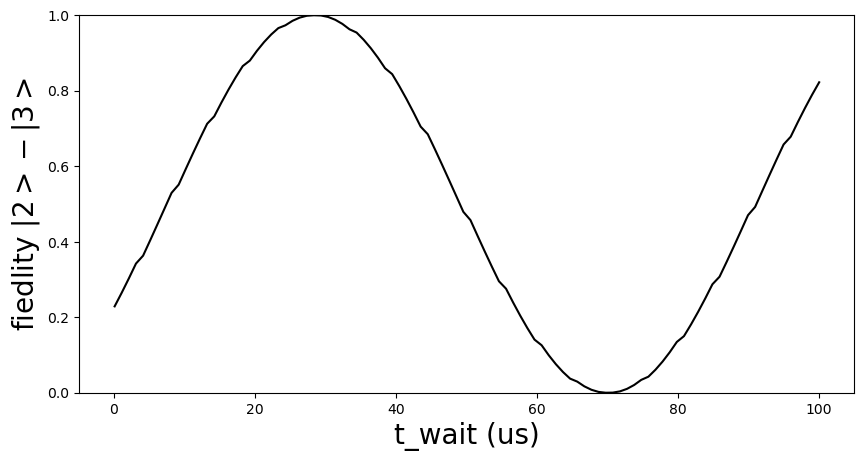

In [181]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(twait_ls*1e6, fidelity, color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r't_wait (us)', fontsize=20)
axes.set_ylabel(r'fiedlity $|2>-|3>$', fontsize=20)
axes.set_ylim(0., 1)
#axes.set_xlim(0, 0.01)

## function of polarization

In [204]:

def Hp_coeff(t, args):
    return np.exp(1j*delta*t)

def Hm_coeff(t, args):
    return np.exp(-1j*delta*t)


result_ls = []

B_ls = 4.8*6.8e-4

phi_ls = np.linspace(-np.pi/36-np.pi/2, np.pi/36-np.pi/2, 20)
angle_pol_ls = np.linspace(np.pi/4-np.pi/36, np.pi/4+np.pi/36, 20)

i=0


for phi_1 in phi_ls:
    for angle_pol_1 in angle_pol_ls:
    

        delta_Ne = -2*np.pi*582*B*1e4 #excited
        delta_Ng = -2*np.pi*375*B*1e4 #ground


        ##########################################
        ## Hamiltonian 1: 1st sigma pulse 4-->2 ##
        #####################################3####

        #diagonal terms for the first pulse
        diag_1_1 = -delta_Ng
        diag_2_1 = -delta_Ne
        diag_3_1 = delta_Ne
        diag_4_1 = delta_Ng

        # off-diagonal terms 
        #phi_1 = -np.pi/2
        #angle_pol_1 = np.pi/4
        polarization_1 = (np.cos(angle_pol_1)*x+np.sin(angle_pol_1)*np.exp(-1j*phi_1)*z)

        offdiag_21_1 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization_1, pi_pol)) / 2
        offdiag_31_1 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization_1, sigp_pol)) / 2
        offdiag_24_1 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization_1, sigm_pol)) / 2
        offdiag_34_1 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization_1, pi_pol)) / 2


        H1_diag = diag_1_1*sig_11 + diag_2_1*sig_22 + diag_3_1*sig_33 + diag_4_1*sig_44

        H1_offdiag = offdiag_21_1*sig_21 + offdiag_31_1*sig_31 + offdiag_24_1*sig_24 + offdiag_34_1*sig_34

        H1_conj = ( np.conjugate(offdiag_21_1)*sig_12 + np.conjugate(offdiag_31_1)*sig_13 + 
                    np.conjugate(offdiag_24_1)*sig_42 + np.conjugate(offdiag_34_1)*sig_43 )

        ###################################
        # calibrate pi
        ############################
        psi0 = four
        psi_i =  two

        dt = 1e-8
        t_ls = np.arange(0, 1000*dt, dt)

        delta = (delta_Ng+delta_Ne)

        output = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], psi0, t_ls, 
                          c_ops, [psi_i*psi_i.dag()], options=options)

        pi_time_idx = np.where(output.expect[0] == np.max(output.expect[0]))[0][0]
        pi_time1 = t_ls[pi_time_idx]


        ##########################################
        ## Hamiltonian 2: 2nd sigma pulse 1-->3 ##
        #####################################3####

        #diagonal terms for the first pulse
        diag_1_2 = -delta_Ng
        diag_2_2 = -delta_Ne
        diag_3_2 = delta_Ne
        diag_4_2 = delta_Ng

        # off-diagonal terms 
        phi_2 = +np.pi/2
        angle_pol_2 = np.pi/4
        polarization_2 = (np.cos(angle_pol_2)*x+np.sin(angle_pol_2)*np.exp(-1j*phi_2)*z)

        offdiag_21_2 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization_2, pi_pol)) / 2
        offdiag_31_2 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization_2, sigp_pol)) / 2
        offdiag_24_2 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization_2, sigm_pol)) / 2
        offdiag_34_2 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization_2, pi_pol)) / 2


        H2_diag = diag_1_2*sig_11 + diag_2_2*sig_22 + diag_3_2*sig_33 + diag_4_2*sig_44

        H2_offdiag = offdiag_21_2*sig_21 + offdiag_31_2*sig_31 + offdiag_24_2*sig_24 + offdiag_34_2*sig_34

        H2_conj = ( np.conjugate(offdiag_21_2)*sig_12 + np.conjugate(offdiag_31_2)*sig_13 + 
                    np.conjugate(offdiag_24_2)*sig_42 + np.conjugate(offdiag_34_2)*sig_43 )

        ###################################
        # calibrate pi
        ############################
        psi0 = one
        psi_i = three

        dt = 1e-8
        t_ls = np.arange(0, 1000*dt, dt)

        delta = -(delta_Ng+delta_Ne)

        output = mesolve([H2_diag, [H2_offdiag, Hp_coeff], [H2_conj, Hm_coeff]], psi0, t_ls, 
                          c_ops, [psi_i*psi_i.dag()], options=options)

        pi_time_idx = np.where(output.expect[0] == np.max(output.expect[0]))[0][0]
        pi_time2 = t_ls[pi_time_idx]


        ##########################################
        ## Hamiltonian wait:                    ##
        #####################################3####

        LS = 2*np.pi*50e3
        #diagonal terms for the first pulse
        diag_1_w = -delta_Ng + LS/2
        diag_2_w = -delta_Ne - LS/2
        diag_3_w = delta_Ne - LS/2
        diag_4_w = delta_Ng + LS/2

        H_wait = diag_1_w*sig_11 + diag_2_w*sig_22 + diag_3_w*sig_33 + diag_4_w*sig_44


        ###################################
        psi0 = 1/np.sqrt(2)*(one+four)
        psi_i = 1/np.sqrt(2)*(two-three)

        dt = 1e-8
        t_ls1 = np.arange(0, 1000*dt, dt)

        delta = (delta_Ng+delta_Ne)

        psi1 = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], psi0, 
                       np.linspace(0, pi_time1, 30), c_ops, 
                       options=options).states[-1]

        twait = 1e-6
        psi2 = mesolve(H_wait, psi1, 
                       np.arange(pi_time1, pi_time1+twait, pi_time1/30), c_ops, 
                       options=options).states[-1]

        psi3_ls = []
        for clockphase in np.linspace(0, 2*np.pi, 100):
            delta = -(delta_Ng+delta_Ne)
            psi3 = mesolve([H2_diag, [H2_offdiag*np.exp(-1j*clockphase), Hp_coeff], [H2_conj*np.exp(1j*clockphase), Hm_coeff]], psi2, 
                           np.linspace(pi_time1+twait, pi_time1+twait+pi_time2, 30), c_ops, 
                           [psi_i*psi_i.dag()], 
                           options=options).expect[0][-1]
            psi3_ls.append(psi3)

        result_ls.append([np.max(psi3_ls), phi_1, angle_pol_1])
        i +=1
        
    print(i)


20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400


In [207]:
fidelity = np.array(result_ls)[:, 0]
fidelity = fidelity.reshape(len(phi_ls), len(angle_pol_ls))

Text(0.5, 0, 'angle between hor and ver (deg)')

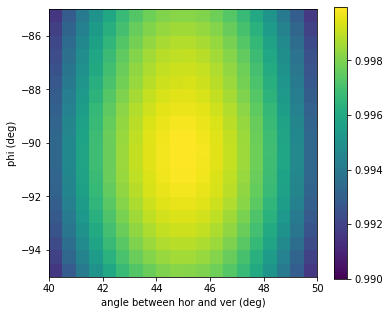

In [209]:
extent = np.min(angle_pol_ls)*180/np.pi, np.max(angle_pol_ls)*180/np.pi, np.min(phi_ls)*180/np.pi, np.max(phi_ls)*180/np.pi
plt.figure(figsize=(6,5))
plt.imshow(fidelity, cmap=plt.cm.viridis, origin='lower',
    extent=extent, vmin=0.99, aspect = (extent[1]-extent[0])/(extent[3]-extent[2]))
plt.colorbar()
plt.ylabel('phi (deg)')
plt.xlabel('angle between hor and ver (deg)')